ESA SpOC 2023 - Quantum Communications Constellations
NSGA-II Optimization Solver
Starting NSGA-II optimization for ESA Quantum Communications Problem...
Population size: 50
Max generations: 200
Problem dimensions: 20 variables, 2 objectives, 2 constraints
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       50 |      7 |  0.000000E+00 |  4.170207E+02 |             - |             -
     2 |      100 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0052584540 |         ideal
     3 |      150 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0699313763 |         ideal
     4 |      200 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0374104776 |             f
     5 |      250 |     23 |  0.000000E+00 |  0.000000E+00 |  0.4969047014 |         nadir
     6 |      300 |     26 |  0.000000E+00 |  0.000000E+00 |  0.6601546322 |         nadir
     7 |      350 |     31 |  0.000000E+00 |  0.000000E+00 |  0.4937824361 |         nadir
     8 |      4

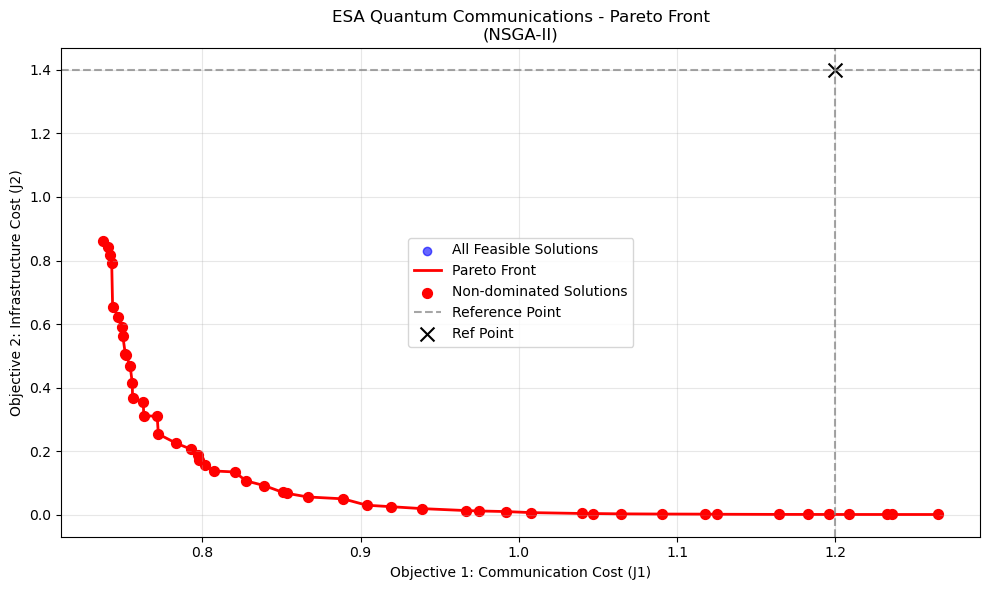


Saved 50 best solutions to files:
  - esa_nsga2_solutions.npz
  - esa_nsga2_solutions.txt
  - esa_nsga2_objectives.txt
📊 Dettagli di tutte le soluzioni salvati in 'esa_detailed_solutions.csv'

🎯 VALIDAZIONE MIGLIORE SOLUZIONE DI COMPROMESSO (indice 48):

DETTAGLI SOLUZIONE OTTIMALE

--- COSTELLAZIONE WALKER 1 ---
a1 (semi-major axis): 1.606134
e1 (eccentricity): 0.004252
i1 (inclination): 0.376140 rad (21.55°)
w1 (argument of perigee): 0.908796 rad (52.07°)
eta1 (quality factor): 296.375372
S1 (sats per plane): 4
P1 (number of planes): 3
F1 (phasing): 1
Total satellites Walker 1: 12

--- COSTELLAZIONE WALKER 2 ---
a2 (semi-major axis): 2.956251
e2 (eccentricity): 0.067271
i2 (inclination): 0.511334 rad (29.30°)
w2 (argument of perigee): 4.941736 rad (283.14°)
eta2 (quality factor): 209.852117
S2 (sats per plane): 5
P2 (number of planes): 3
F2 (phasing): 6
Total satellites Walker 2: 15

--- SELEZIONE ROVER ---
Rover 1 index: 44
Rover 2 index: 43
Rover 3 index: 37
Rover 4 index: 77

---

In [1]:
#!/usr/bin/env python3
"""
NSGA-II Solver for ESA SpOC 2023 Quantum Communications Constellations
"""

import numpy as np
import multiprocessing as mp
mp.set_start_method('spawn', force=True)

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt

# Importa il codice del problema ESA che hai già
from constellations_udp import constellation_udp, get_mothership_satellites

# Inizializza il problema
udp = constellation_udp()
bounds_lb, bounds_ub = udp.get_bounds()

class ESAQuantumCommProblem(ElementwiseProblem):
    def __init__(self):
        self.udp = constellation_udp()
        lb, ub = self.udp.get_bounds()
        
        # Converti i bounds per PyMOO
        xl = np.array(lb)
        xu = np.array(ub)
        
        super().__init__(
            n_var=len(xl),
            n_obj=2,
            n_constr=2,
            xl=xl,
            xu=xu
        )
    
    def _evaluate(self, x, out, *args, **kwargs):
        # Converti gli ultimi 10 parametri in interi (S1, P1, F1, S2, P2, F2, r1, r2, r3, r4)
        x_int = x.copy()
        x_int[10:16] = np.round(x_int[10:16])  # S1, P1, F1, S2, P2, F2
        x_int[16:20] = np.round(x_int[16:20])  # r1, r2, r3, r4
        
        # Calcola la fitness
        try:
            result = self.udp.fitness(x_int)
            f1, f2, c1, c2 = result
            
            # Obiettivi da minimizzare
            out["F"] = [f1, f2]
            # Vincoli (deve essere <= 0)
            out["G"] = [c1, c2]
            
        except Exception as e:
            # In caso di errore, restituisci valori pessimi
            print(f"Error evaluating solution: {e}")
            out["F"] = [1000.0, 1000.0]
            out["G"] = [1000.0, 1000.0]

def create_nsga2_algorithm(pop_size=100):
    """Crea e configura l'algoritmo NSGA-II"""
    
    algorithm = NSGA2(
        pop_size=pop_size,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20),
        eliminate_duplicates=True
    )
    
    return algorithm

def run_nsga2_optimization():
    """Esegue l'ottimizzazione con NSGA-II"""
    
    # Crea il problema
    problem = ESAQuantumCommProblem()
    
    # Configura l'algoritmo
    algorithm = create_nsga2_algorithm(pop_size=100)
    
    # Configura la terminazione
    termination = get_termination("n_gen", 200)
    
    print("Starting NSGA-II optimization for ESA Quantum Communications Problem...")
    print(f"Population size: {algorithm.pop_size}")
    print(f"Max generations: {termination.n_max_gen}")
    print(f"Problem dimensions: {problem.n_var} variables, {problem.n_obj} objectives, {problem.n_constr} constraints")
    
    # Esegui l'ottimizzazione
    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=42,
                   verbose=True,
                   save_history=True)
    
    return res, problem

def validate_solution_detailed(x):
    """Valida una soluzione specifica con stampa dettagliata"""
    udp_local = constellation_udp()
    
    # Converti in interi
    x_int = x.copy()
    x_int[10:16] = np.round(x_int[10:16])  # S1, P1, F1, S2, P2, F2
    x_int[16:20] = np.round(x_int[16:20])  # r1, r2, r3, r4
    
    result = udp_local.fitness(x_int)
    f1, f2, c1, c2 = result
    
    print("\n" + "="*60)
    print("DETTAGLI SOLUZIONE OTTIMALE")
    print("="*60)
    
    # Stampa tutti i parametri
    print("\n--- COSTELLAZIONE WALKER 1 ---")
    print(f"a1 (semi-major axis): {x_int[0]:.6f}")
    print(f"e1 (eccentricity): {x_int[1]:.6f}")
    print(f"i1 (inclination): {x_int[2]:.6f} rad ({np.degrees(x_int[2]):.2f}°)")
    print(f"w1 (argument of perigee): {x_int[3]:.6f} rad ({np.degrees(x_int[3]):.2f}°)")
    print(f"eta1 (quality factor): {x_int[4]:.6f}")
    print(f"S1 (sats per plane): {int(x_int[10])}")
    print(f"P1 (number of planes): {int(x_int[11])}")
    print(f"F1 (phasing): {int(x_int[12])}")
    print(f"Total satellites Walker 1: {int(x_int[10]) * int(x_int[11])}")
    
    print("\n--- COSTELLAZIONE WALKER 2 ---")
    print(f"a2 (semi-major axis): {x_int[5]:.6f}")
    print(f"e2 (eccentricity): {x_int[6]:.6f}")
    print(f"i2 (inclination): {x_int[7]:.6f} rad ({np.degrees(x_int[7]):.2f}°)")
    print(f"w2 (argument of perigee): {x_int[8]:.6f} rad ({np.degrees(x_int[8]):.2f}°)")
    print(f"eta2 (quality factor): {x_int[9]:.6f}")
    print(f"S2 (sats per plane): {int(x_int[13])}")
    print(f"P2 (number of planes): {int(x_int[14])}")
    print(f"F2 (phasing): {int(x_int[15])}")
    print(f"Total satellites Walker 2: {int(x_int[13]) * int(x_int[14])}")
    
    print("\n--- SELEZIONE ROVER ---")
    print(f"Rover 1 index: {int(x_int[16])}")
    print(f"Rover 2 index: {int(x_int[17])}")
    print(f"Rover 3 index: {int(x_int[18])}")
    print(f"Rover 4 index: {int(x_int[19])}")
    
    # Coordinate dei rover selezionati
    rovers_idx = np.array(x_int[16:20]).astype(int)
    lambdas = udp_local.lambdas[rovers_idx]
    phis = udp_local.phis[rovers_idx]
    
    print("\n--- COORDINATE ROVER (lat, lon) ---")
    for i, (lat, lon) in enumerate(zip(lambdas, phis)):
        print(f"Rover {i+1}: ({lat:.6f}, {lon:.6f})")
    
    print("\n--- PERFORMANCE ---")
    print(f"Communication cost (J1): {f1:.6f}")
    print(f"Infrastructure cost (J2): {f2:.6f}")
    print(f"Rover distance constraint: {c1:.2f} km (should be <= 0)")
    print(f"Satellite distance constraint: {c2:.2f} km (should be <= 0)")
    print(f"Feasible: {c1 <= 0 and c2 <= 0}")
    
    print(f"\nTotal satellites: {int(x_int[10]) * int(x_int[11]) + int(x_int[13]) * int(x_int[14])}")
    print(f"Total cost (J1 + J2): {f1 + f2:.6f}")
    
    print("="*60)
    
    return result

def analyze_results(res, problem):
    """Analizza e visualizza i risultati"""
    
    print("\n" + "="*50)
    print("OPTIMIZATION RESULTS")
    print("="*50)
    
    # Filtra soluzioni ammissibili (vincoli soddisfatti)
    feasible_mask = np.all(res.G <= 0, axis=1)
    feasible_solutions = res.X[feasible_mask]
    feasible_objectives = res.F[feasible_mask]
    
    print(f"Total solutions found: {len(res.X)}")
    print(f"Feasible solutions: {len(feasible_solutions)}")
    print(f"Best hypervolume solutions: {len(feasible_objectives)}")
    
    if len(feasible_objectives) > 0:
        # Calcola metriche sulle soluzioni ammissibili
        best_f1 = np.min(feasible_objectives[:, 0])
        best_f2 = np.min(feasible_objectives[:, 1])
        
        print(f"Best F1 (communication cost): {best_f1:.4f}")
        print(f"Best F2 (infrastructure cost): {best_f2:.4f}")
        
        # Trova le soluzioni non dominate
        from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
        nds = NonDominatedSorting().do(feasible_objectives)
        pareto_front = feasible_objectives[nds[0]]
        
        print(f"Pareto front solutions: {len(pareto_front)}")
        
        # Visualizza il fronte di Pareto
        plot_pareto_front(pareto_front, feasible_objectives)
        
        # Salva le migliori soluzioni
        save_best_solutions(feasible_solutions[nds[0]], feasible_objectives[nds[0]])
    
    return feasible_solutions, feasible_objectives

def plot_pareto_front(pareto_front, all_solutions):
    """Visualizza il fronte di Pareto"""
    
    plt.figure(figsize=(10, 6))
    
    # Tutte le soluzioni ammissibili
    plt.scatter(all_solutions[:, 0], all_solutions[:, 1], 
                alpha=0.6, label='All Feasible Solutions', color='blue')
    
    # Fronte di Pareto
    pareto_sorted = pareto_front[np.argsort(pareto_front[:, 0])]
    plt.plot(pareto_sorted[:, 0], pareto_sorted[:, 1], 
             'r-', linewidth=2, label='Pareto Front')
    plt.scatter(pareto_front[:, 0], pareto_front[:, 1], 
                color='red', s=50, label='Non-dominated Solutions')
    
    # Punto di riferimento per l'ipervolume
    ref_point = np.array([1.2, 1.4])
    plt.axvline(x=ref_point[0], color='gray', linestyle='--', alpha=0.7, label='Reference Point')
    plt.axhline(y=ref_point[1], color='gray', linestyle='--', alpha=0.7)
    plt.scatter([ref_point[0]], [ref_point[1]], color='black', marker='x', s=100, label='Ref Point')
    
    plt.xlabel('Objective 1: Communication Cost (J1)')
    plt.ylabel('Objective 2: Infrastructure Cost (J2)')
    plt.title('ESA Quantum Communications - Pareto Front\n(NSGA-II)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('esa_nsga2_pareto.png', dpi=300, bbox_inches='tight')
    plt.show()

def save_best_solutions(solutions, objectives):
    """Salva le migliori soluzioni trovate"""
    
    # Seleziona le 100 soluzioni migliori
    n_solutions = min(len(solutions), 100)
    selected_indices = np.arange(n_solutions)
    
    if len(solutions) > 100:
        # Se abbiamo più di 100 soluzioni, seleziona quelle più diverse
        from pymoo.util.nds import non_dominated_sorting
        fronts = non_dominated_sorting(objectives)
        selected_indices = []
        
        for front in fronts:
            if len(selected_indices) + len(front) <= 100:
                selected_indices.extend(front)
            else:
                # Per l'ultimo fronte, seleziona le più diverse
                remaining = 100 - len(selected_indices)
                front_solutions = solutions[front]
                
                # Selezione per diversità (crowding distance)
                from pymoo.util.nds import crowding_distance
                crowding = crowding_distance(objectives[front])
                best_indices = np.argsort(crowding)[-remaining:]
                selected_indices.extend(front[best_indices])
                break
    
    best_solutions = solutions[selected_indices]
    best_objectives = objectives[selected_indices]
    
    # Salva in formato numpy
    np.savez_compressed('esa_nsga2_solutions.npz',
                       xs=best_solutions,
                       ys=best_objectives)
    
    print(f"\nSaved {len(best_solutions)} best solutions to files:")
    print("  - esa_nsga2_solutions.npz")


def save_detailed_solutions(solutions, objectives):
    """Salva i dettagli delle soluzioni in file CSV"""
    try:
        import pandas as pd
        
        data = []
        for i, (x, obj) in enumerate(zip(solutions, objectives)):
            # Converti in interi per il salvataggio
            x_int = x.copy()
            x_int[10:16] = np.round(x_int[10:16])
            x_int[16:20] = np.round(x_int[16:20])
            
            row = {
                'solution_id': i,
                'J1_communication': obj[0],
                'J2_infrastructure': obj[1],
                'a1': x_int[0], 'e1': x_int[1], 'i1': x_int[2], 'w1': x_int[3], 'eta1': x_int[4],
                'a2': x_int[5], 'e2': x_int[6], 'i2': x_int[7], 'w2': x_int[8], 'eta2': x_int[9],
                'S1': int(x_int[10]), 'P1': int(x_int[11]), 'F1': int(x_int[12]),
                'S2': int(x_int[13]), 'P2': int(x_int[14]), 'F2': int(x_int[15]),
                'rover1': int(x_int[16]), 'rover2': int(x_int[17]), 'rover3': int(x_int[18]), 'rover4': int(x_int[19]),
                'total_sats': int(x_int[10])*int(x_int[11]) + int(x_int[13])*int(x_int[14])
            }
            data.append(row)
        
        df = pd.DataFrame(data)
        df.to_csv('esa_detailed_solutions.csv', index=False)
        print(f"📊 Dettagli di tutte le soluzioni salvati in 'esa_detailed_solutions.csv'")
    except ImportError:
        print("⚠️  Pandas non installato. Salto il salvataggio in CSV.")
        print("Installa con: pip install pandas")

if __name__ == "__main__":
    print("ESA SpOC 2023 - Quantum Communications Constellations")
    print("NSGA-II Optimization Solver")
    print("=" * 60)
    
    # Esegui l'ottimizzazione
    res, problem = run_nsga2_optimization()
    
    # Analizza i risultati
    feasible_solutions, feasible_objectives = analyze_results(res, problem)
    
    if len(feasible_solutions) > 0:
        # Salva i dettagli in file
        save_detailed_solutions(feasible_solutions, feasible_objectives)
        
        # Valida SOLO la migliore soluzione per compromesso
        best_idx = np.argmin(feasible_objectives[:, 0] + feasible_objectives[:, 1])
        best_solution = feasible_solutions[best_idx]
        print(f"\n🎯 VALIDAZIONE MIGLIORE SOLUZIONE DI COMPROMESSO (indice {best_idx}):")
        validate_solution_detailed(best_solution)
    
    print("\nOptimization completed successfully!")

ESA SpOC 2023 - Visualizzatore 3D Avanzato Costellazioni Walker

🎯 Soluzione di compromesso ottimale (indice 48)
📊 Obiettivo J1: 0.8532
📊 Obiettivo J2: 0.0670


[1/2] Visualizzazione completa con tutti gli elementi...
Walker 1: 4 satelliti × 3 piani = 12 satelliti totali
  - Semi-asse maggiore: 1.6 km
  - Inclinazione: 21.6°
Walker 2: 5 satelliti × 3 piani = 15 satelliti totali
  - Semi-asse maggiore: 3.0 km
  - Inclinazione: 29.3°

Plot salvato in: nsga2_3d_visualization_enhanced.png



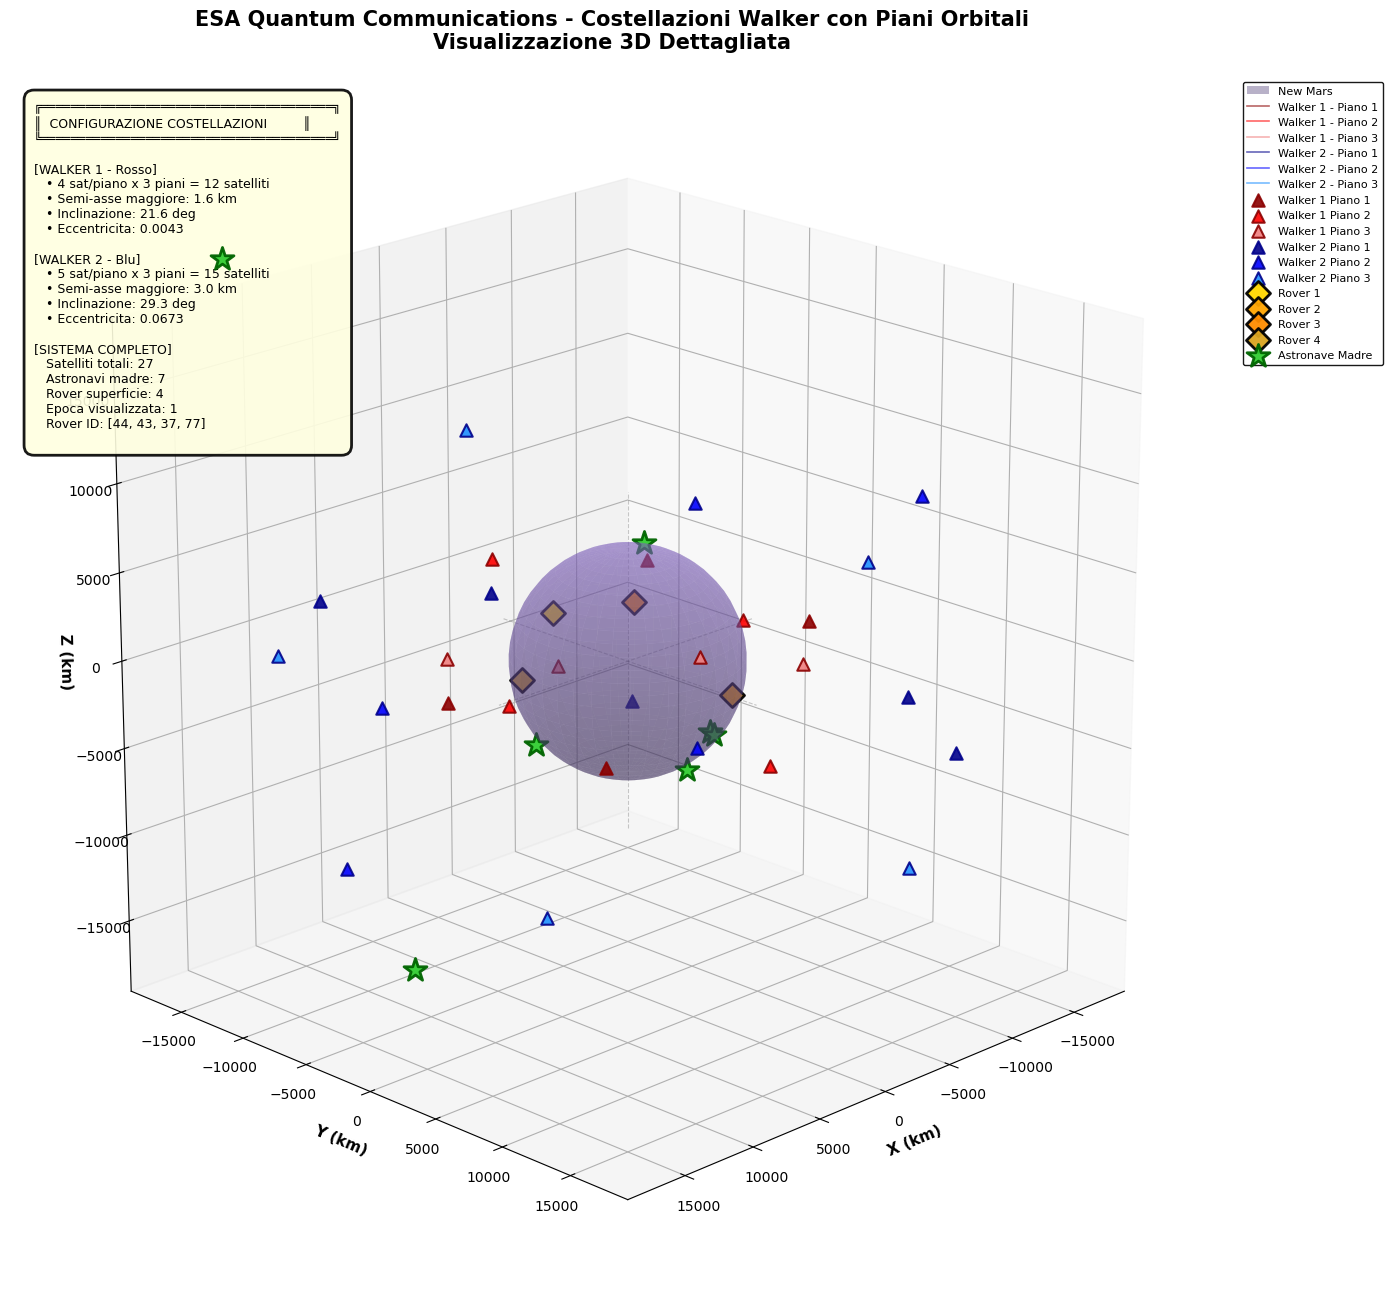


[2/2] Visualizzazione rete di comunicazione quantistica...
   Collegamenti Mothership-Sat: 107
   Collegamenti Sat-Sat: 235
   Collegamenti Rover-Sat/Mothership: 14
   Totale collegamenti: 356

Plot rete comunicazione salvato in: nsga2_communication_network.png



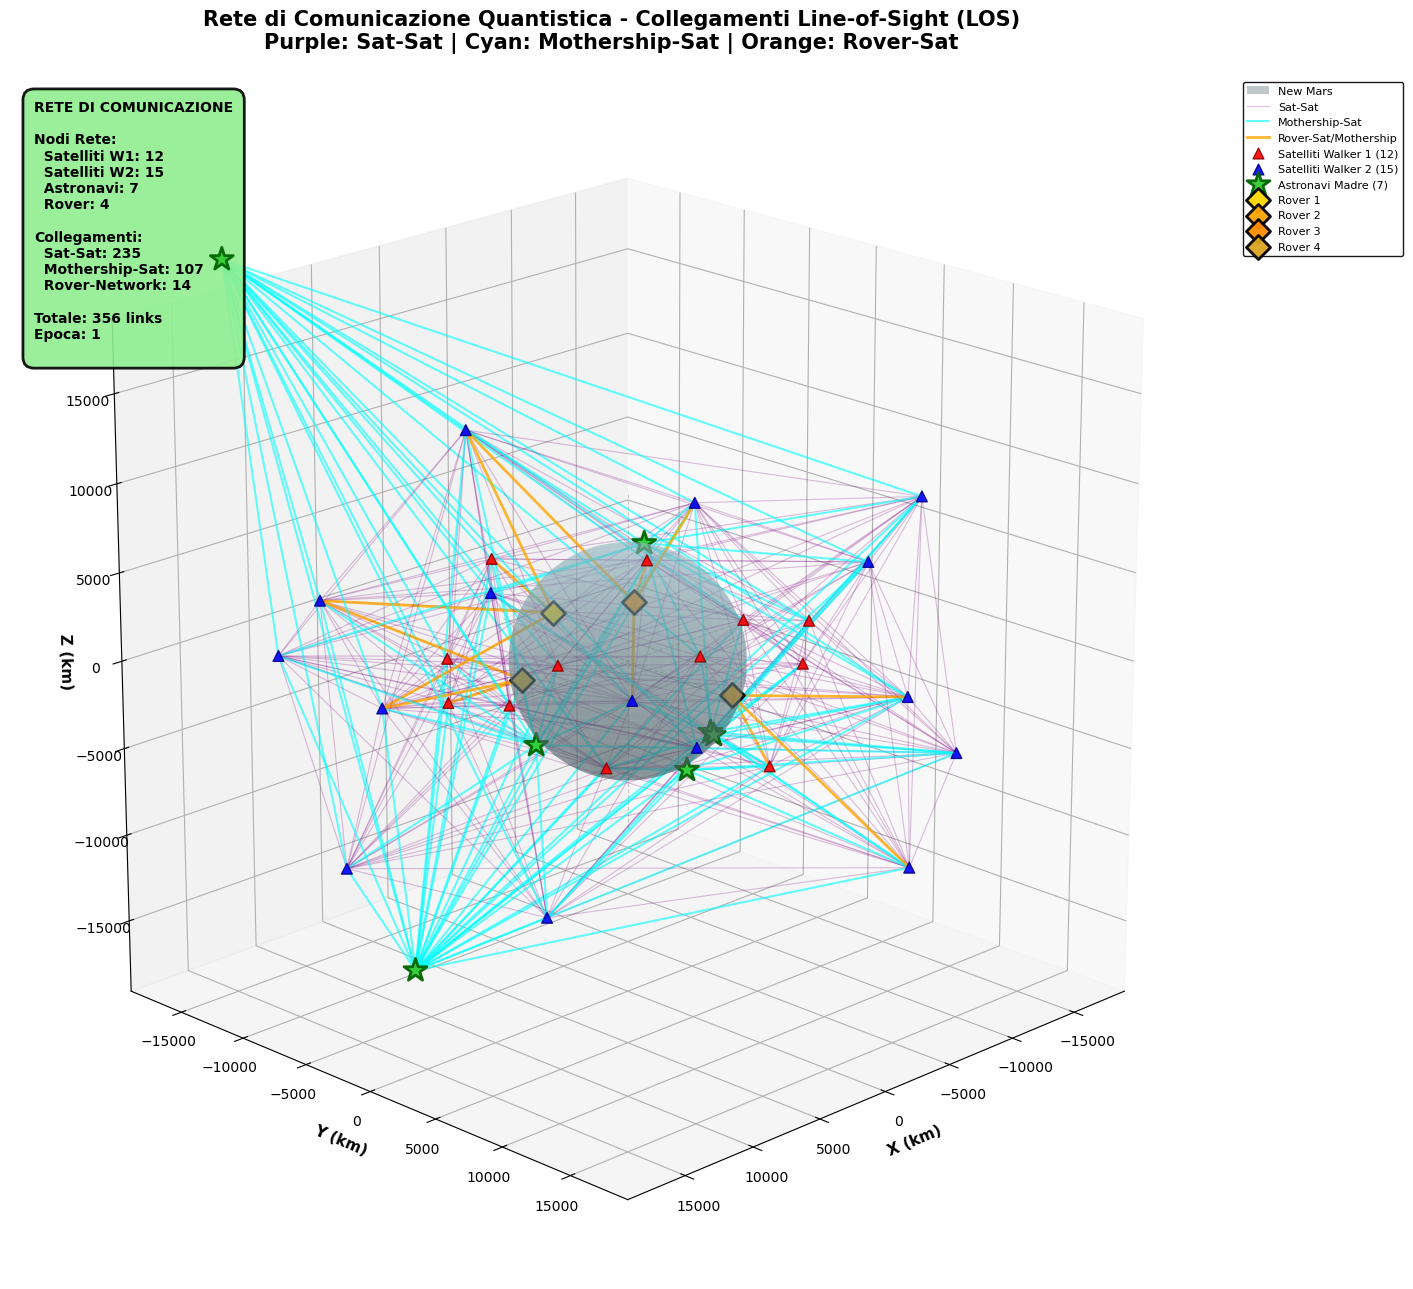


 Visualizzazioni completate con successo!
File salvati:
  - nsga2_3d_visualization_enhanced.png (vista completa con piani Walker)
  - nsga2_communication_network.png (rete di comunicazione)


In [18]:
#!/usr/bin/env python3
"""
3D Visualization for ESA SpOC 2023 Quantum Communications Constellations
Versione migliorata con visualizzazione esplicita dei piani orbitali Walker
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyBboxPatch
import pykep as pk
from constellations_udp import constellation_udp
import os

def create_3d_visualization(x, epoch_idx=1, save_path=None):
    """
    Crea una visualizzazione 3D completa con piani orbitali Walker evidenziati
    
    Args:
        x: vettore decisionale della soluzione
        epoch_idx: indice dell'epoca da visualizzare (default: 1)
        save_path: percorso per salvare il plot (opzionale)
    """
    
    # Inizializza il problema
    udp = constellation_udp()
    
    # Converti in interi
    x_int = x.copy()
    x_int[10:16] = np.round(x_int[10:16])
    x_int[16:20] = np.round(x_int[16:20])
    
    # Costruisci le costellazioni Walker
    walker1, walker2 = udp.construct_walkers(x_int)
    
    # Estrai parametri
    a1, e1, i1, w1, eta1 = x_int[0:5]
    a2, e2, i2, w2, eta2 = x_int[5:10]
    S1, P1, F1 = int(x_int[10]), int(x_int[11]), int(x_int[12])
    S2, P2, F2 = int(x_int[13]), int(x_int[14]), int(x_int[15])
    
    # Coordinate rover
    rovers_idx = np.array(x_int[16:20]).astype(int)
    lambda0 = udp.lambdas[rovers_idx]
    phi0 = udp.phis[rovers_idx]
    
    
    print(f"Walker 1: {S1} satelliti × {P1} piani = {S1*P1} satelliti totali")
    print(f"  - Semi-asse maggiore: {a1:.1f} km")
    print(f"  - Inclinazione: {np.rad2deg(i1):.1f}°")
    print(f"Walker 2: {S2} satelliti × {P2} piani = {S2*P2} satelliti totali")
    print(f"  - Semi-asse maggiore: {a2:.1f} km")
    print(f"  - Inclinazione: {np.rad2deg(i2):.1f}°")
    
    # Crea figura 3D
    fig = plt.figure(figsize=(18, 13))
    ax = fig.add_subplot(111, projection='3d')
    
    # Configurazione del plot
    ax.set_xlabel('X (km)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Y (km)', fontsize=11, fontweight='bold')
    ax.set_zlabel('Z (km)', fontsize=11, fontweight='bold')
    ax.set_title('ESA Quantum Communications - Costellazioni Walker con Piani Orbitali\nVisualizzazione 3D Dettagliata', 
                 fontsize=15, fontweight='bold', pad=20)
    
    # 1. DISEGNA IL PIANETA "NEW MARS"
    plot_planet_sphere(ax, udp.R_p, "New Mars", "mediumpurple")
    
    # 2. DISEGNA I PIANI ORBITALI WALKER 1 (con colori distinti per piano)
    plot_walker_orbital_planes(ax, walker1, udp.jds[epoch_idx], a1, S1, P1, 
                               "Walker 1", "red", show_plane_discs=True)
    
    # 3. DISEGNA I PIANI ORBITALI WALKER 2 (con colori distinti per piano)
    plot_walker_orbital_planes(ax, walker2, udp.jds[epoch_idx], a2, S2, P2, 
                               "Walker 2", "blue", show_plane_discs=True)
    
    # 4. DISEGNA I SATELLITI CON ETICHETTE PER PIANO
    plot_satellite_positions_by_plane(ax, walker1, walker2, udp, epoch_idx, S1, P1, S2, P2)
    
    # 5. DISEGNA I ROVER SULLA SUPERFICIE
    plot_rovers_on_surface(ax, lambda0, phi0, udp, epoch_idx)
    
    # 6. DISEGNA LE ASTRONAVI MADRE
    plot_mothership_positions(ax, udp, epoch_idx)
    
    # 7. AGGIUNGI LEGGENDA DETTAGLIATA E INFORMAZIONI
    add_enhanced_legend_and_info(ax, x_int, udp, epoch_idx, S1, P1, S2, P2)
    
    # Configura vista e limiti
    setup_3d_view(ax, udp.R_p)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nPlot salvato in: {save_path}\n")
    
    plt.show()
    
    return fig, ax

def plot_planet_sphere(ax, radius, name, color):
    """Disegna il pianeta come una sfera con migliore rendering"""
    u = np.linspace(0, 2 * np.pi, 40)
    v = np.linspace(0, np.pi, 30)
    
    x = radius * np.outer(np.cos(u), np.sin(v))
    y = radius * np.outer(np.sin(u), np.sin(v))
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
    
    ax.plot_surface(x, y, z, color=color, alpha=0.4, label=name, 
                   linewidth=0, antialiased=True, shade=True)
    
    # Aggiungi coordinate assiali
    max_coord = radius * 1.5
    ax.plot([-max_coord, max_coord], [0, 0], [0, 0], 'k--', alpha=0.2, linewidth=0.8)
    ax.plot([0, 0], [-max_coord, max_coord], [0, 0], 'k--', alpha=0.2, linewidth=0.8)
    ax.plot([0, 0], [0, 0], [-max_coord, max_coord], 'k--', alpha=0.2, linewidth=0.8)

def plot_walker_orbital_planes(ax, walker_array, jd_epoch, semi_major_axis, 
                               sats_per_plane, num_planes, label, base_color, 
                               show_plane_discs=False):
    """
    Disegna le orbite della costellazione Walker con evidenziazione dei piani orbitali
    
    Args:
        show_plane_discs: se True, disegna anche i dischi trasparenti dei piani orbitali
    """
    try:
        # Calcola periodo orbitale
        mean_motion = np.sqrt(pk.MU_EARTH / (semi_major_axis * 1000)**3) * 24 * 60 * 60 / (2 * np.pi)
        jds_orbit = np.linspace(jd_epoch, jd_epoch + 1/mean_motion, 150)
        frs_orbit = jds_orbit * 0.0
        
        # Propaga tutti i satelliti
        err, pos, _ = walker_array.sgp4(jds_orbit, frs_orbit)
        
        if np.all(err == 0):
            # Colori diversi per ogni piano orbitale
            if base_color == "red":
                plane_colors = ['darkred', 'red', 'lightcoral', 'indianred', 'salmon']
            else:  # blue
                plane_colors = ['darkblue', 'blue', 'dodgerblue', 'lightskyblue', 'cornflowerblue']
            
            # Disegna le orbite per ogni piano
            total_sats = sats_per_plane * num_planes
            for plane_idx in range(num_planes):
                # Satelliti in questo piano
                sat_indices = range(plane_idx * sats_per_plane, (plane_idx + 1) * sats_per_plane)
                
                color = plane_colors[plane_idx % len(plane_colors)]
                
                for i, sat_idx in enumerate(sat_indices):
                    if sat_idx < len(walker_array):
                        # Label solo per il primo satellite del piano
                        plane_label = f"{label} - Piano {plane_idx+1}" if i == 0 else ""
                        
                        ax.plot(pos[sat_idx, :, 0], pos[sat_idx, :, 1], pos[sat_idx, :, 2], 
                               color=color, alpha=0.6, linewidth=1.2, label=plane_label)
                
                # Opzionale: disegna disco trasparente del piano orbitale
                if show_plane_discs and plane_idx == 0:  # Solo per il primo piano per non sovraccaricare
                    plot_orbital_plane_disc(ax, pos[plane_idx * sats_per_plane, :, :], 
                                          semi_major_axis, color, 0.05)
        else:
            print(f"Errore nella propagazione delle orbite per {label}")
            
    except Exception as e:
        print(f"Errore nel plotting delle orbite {label}: {e}")

def plot_orbital_plane_disc(ax, orbit_positions, radius, color, alpha):
    """Disegna un disco trasparente che rappresenta il piano orbitale"""
    try:
        # Calcola il piano orbitale usando 3 punti dell'orbita
        p1 = orbit_positions[0, :]
        p2 = orbit_positions[len(orbit_positions)//3, :]
        p3 = orbit_positions[2*len(orbit_positions)//3, :]
        
        # Calcola normale al piano
        v1 = p2 - p1
        v2 = p3 - p1
        normal = np.cross(v1, v2)
        normal = normal / np.linalg.norm(normal)
        
        # Crea griglia circolare nel piano
        theta = np.linspace(0, 2*np.pi, 30)
        r = np.linspace(0, radius * 1.2, 10)
        
        # Trova due vettori ortogonali nel piano
        if abs(normal[2]) < 0.9:
            v1 = np.cross(normal, [0, 0, 1])
        else:
            v1 = np.cross(normal, [1, 0, 0])
        v1 = v1 / np.linalg.norm(v1)
        v2 = np.cross(normal, v1)
        
        # Crea mesh del disco
        T, R = np.meshgrid(theta, r)
        X = R * np.cos(T)
        Y = R * np.sin(T)
        
        # Trasforma nel piano orbitale
        disc_x = X * v1[0] + Y * v2[0]
        disc_y = X * v1[1] + Y * v2[1]
        disc_z = X * v1[2] + Y * v2[2]
        
        ax.plot_surface(disc_x, disc_y, disc_z, color=color, alpha=alpha, 
                       linewidth=0, antialiased=True)
        
    except Exception as e:
        print(f"Errore nel plotting del disco orbitale: {e}")

def plot_satellite_positions_by_plane(ax, walker1, walker2, udp, epoch_idx, S1, P1, S2, P2):
    """Disegna i satelliti con colori diversi per piano orbitale"""
    try:
        # Calcola posizioni all'epoca specificata
        jd_single = np.array([udp.jds[epoch_idx]])
        fr_single = np.array([udp.frs[epoch_idx]])
        
        # Colori per piani Walker 1
        colors_w1 = ['darkred', 'red', 'lightcoral', 'indianred', 'salmon']
        
        # Walker 1 - Satelliti colorati per piano
        err1, pos1, _ = walker1.sgp4(jd_single, fr_single)
        if np.all(err1 == 0):
            for plane_idx in range(P1):
                sat_indices = range(plane_idx * S1, (plane_idx + 1) * S1)
                color = colors_w1[plane_idx % len(colors_w1)]
                
                for i, sat_idx in enumerate(sat_indices):
                    if sat_idx < len(walker1):
                        label = f'Walker 1 Piano {plane_idx+1}' if i == 0 else ""
                        ax.scatter(pos1[sat_idx, 0, 0], pos1[sat_idx, 0, 1], pos1[sat_idx, 0, 2], 
                                  c=color, marker='^', s=80, label=label, alpha=0.9, 
                                  edgecolors='darkred', linewidth=1.5)
        
        # Colori per piani Walker 2
        colors_w2 = ['darkblue', 'blue', 'dodgerblue', 'lightskyblue', 'cornflowerblue']
        
        # Walker 2 - Satelliti colorati per piano
        err2, pos2, _ = walker2.sgp4(jd_single, fr_single)
        if np.all(err2 == 0):
            for plane_idx in range(P2):
                sat_indices = range(plane_idx * S2, (plane_idx + 1) * S2)
                color = colors_w2[plane_idx % len(colors_w2)]
                
                for i, sat_idx in enumerate(sat_indices):
                    if sat_idx < len(walker2):
                        label = f'Walker 2 Piano {plane_idx+1}' if i == 0 else ""
                        ax.scatter(pos2[sat_idx, 0, 0], pos2[sat_idx, 0, 1], pos2[sat_idx, 0, 2], 
                                  c=color, marker='^', s=80, label=label, alpha=0.9,
                                  edgecolors='darkblue', linewidth=1.5)
                      
    except Exception as e:
        print(f"Errore nel plotting delle posizioni satelliti: {e}")

def plot_rovers_on_surface(ax, lambda0, phi0, udp, epoch_idx):
    """Disegna i rover sulla superficie con etichette"""
    try:
        pos_r = udp.construct_rover_pos(lambda0, phi0)
        
        rover_colors = ['gold', 'orange', 'darkorange', 'goldenrod']
        rover_labels = ['Rover 1', 'Rover 2', 'Rover 3', 'Rover 4']
        
        for i in range(udp.n_rovers):
            ax.scatter(pos_r[i, epoch_idx, 0], pos_r[i, epoch_idx, 1], pos_r[i, epoch_idx, 2],
                      c=rover_colors[i], marker='D', s=150, label=rover_labels[i], 
                      edgecolors='black', linewidth=2, alpha=0.95)
                      
    except Exception as e:
        print(f"Errore nel plotting dei rover: {e}")

def plot_mothership_positions(ax, udp, epoch_idx):
    """Disegna le astronavi madre con dimensioni maggiori"""
    try:
        for i in range(udp.n_motherships):
            pos = udp.pos_m[i, epoch_idx, :]
            ax.scatter(pos[0], pos[1], pos[2], 
                      c='limegreen', marker='*', s=300, label='Astronave Madre' if i == 0 else "",
                      edgecolors='darkgreen', linewidth=2, alpha=0.95)
                      
    except Exception as e:
        print(f"Errore nel plotting delle astronavi madre: {e}")

def add_enhanced_legend_and_info(ax, x_int, udp, epoch_idx, S1, P1, S2, P2):
    """Aggiunge legenda dettagliata e box informativo"""
    
    # Calcola statistiche
    total_sats_w1 = S1 * P1
    total_sats_w2 = S2 * P2
    total_sats = total_sats_w1 + total_sats_w2
    
    # Testo informativo dettagliato (senza emoji per compatibilità font)
    info_text = f"""╔═══════════════════════════════════════╗
║  CONFIGURAZIONE COSTELLAZIONI         ║
╚═══════════════════════════════════════╝

[WALKER 1 - Rosso]
   • {S1} sat/piano x {P1} piani = {total_sats_w1} satelliti
   • Semi-asse maggiore: {x_int[0]:.1f} km
   • Inclinazione: {np.rad2deg(x_int[2]):.1f} deg
   • Eccentricita: {x_int[1]:.4f}

[WALKER 2 - Blu]
   • {S2} sat/piano x {P2} piani = {total_sats_w2} satelliti
   • Semi-asse maggiore: {x_int[5]:.1f} km
   • Inclinazione: {np.rad2deg(x_int[7]):.1f} deg
   • Eccentricita: {x_int[6]:.4f}

[SISTEMA COMPLETO]
   Satelliti totali: {total_sats}
   Astronavi madre: {udp.n_motherships}
   Rover superficie: {udp.n_rovers}
   Epoca visualizzata: {epoch_idx}
   Rover ID: {[int(x) for x in x_int[16:20]]}
"""
    
    # Posiziona il box informativo (usa un font standard senza monospace per evitare warning)
    ax.text2D(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=9,
              verticalalignment='top', 
              bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', 
                       alpha=0.9, edgecolor='black', linewidth=2),
              family='sans-serif')

def setup_3d_view(ax, planet_radius):
    """Configura la vista 3D con migliore prospettiva"""
    # Imposta limiti appropriati
    limit = planet_radius * 3
    ax.set_xlim([-limit, limit])
    ax.set_ylim([-limit, limit])
    ax.set_zlim([-limit, limit])
    
    # Aspetto uguale
    ax.set_box_aspect([1, 1, 1])
    
    # Legenda fuori dal plot
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=8, 
             framealpha=0.9, edgecolor='black', fancybox=True)
    
    # Grid migliorata
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Angolo di vista ottimale
    ax.view_init(elev=20, azim=45)

def create_communication_links_view(x, epoch_idx=1, save_path=None):
    """
    Visualizza la rete di comunicazione quantistica con collegamenti LOS
    tra satelliti, astronavi madre e rover
    """
    udp = constellation_udp()
    
    # Converti in interi
    x_int = x.copy()
    x_int[10:16] = np.round(x_int[10:16])
    x_int[16:20] = np.round(x_int[16:20])
    
    # Costruisci le costellazioni Walker
    walker1, walker2 = udp.construct_walkers(x_int)
    
    # Estrai parametri
    S1, P1 = int(x_int[10]), int(x_int[11])
    S2, P2 = int(x_int[13]), int(x_int[14])
    N1 = S1 * P1
    N2 = S2 * P2
    
    # Costruisci le posizioni complete
    rovers_idx = np.array(x_int[16:20]).astype(int)
    lambda0 = udp.lambdas[rovers_idx]
    phi0 = udp.phis[rovers_idx]
    rovers = udp.construct_rover_pos(lambda0, phi0)
    cum_pos = udp.construct_pos(walker1, walker2, rovers)
        
    # Crea figura 3D
    fig = plt.figure(figsize=(18, 13))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_xlabel('X (km)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Y (km)', fontsize=11, fontweight='bold')
    ax.set_zlabel('Z (km)', fontsize=11, fontweight='bold')
    ax.set_title('Rete di Comunicazione Quantistica - Collegamenti Line-of-Sight (LOS)\nPurple: Sat-Sat | Cyan: Mothership-Sat | Orange: Rover-Sat', 
                 fontsize=15, fontweight='bold', pad=20)
    
    # Pianeta
    plot_planet_sphere(ax, udp.R_p, "New Mars", "lightblue")
    
    # COSTRUISCI E VISUALIZZA I COLLEGAMENTI
    try:
        eta1, eta2 = x_int[4], x_int[9]
        G, adjmatrix, d_min = udp.build_graph(epoch_idx, cum_pos, N1, (eta1, eta2))
        
        # Conta i collegamenti per tipo
        sat_sat_links = 0
        mothership_sat_links = 0
        rover_sat_links = 0
        
        # Disegna i collegamenti con linea di vista
        for i in range(len(G)):
            for j in range(i+1, len(G)):
                if adjmatrix[i, j] > 0 and adjmatrix[i, j] < 1000:  # Collegamento valido
                    pos_i = cum_pos[i, epoch_idx, :]
                    pos_j = cum_pos[j, epoch_idx, :]
                    
                    # Determina tipo di collegamento
                    is_sat_i = i < N1+N2
                    is_sat_j = j < N1+N2
                    is_mothership_i = (i >= N1+N2 and i < N1+N2+udp.n_motherships)
                    is_mothership_j = (j >= N1+N2 and j < N1+N2+udp.n_motherships)
                    is_rover_i = i >= N1+N2+udp.n_motherships
                    is_rover_j = j >= N1+N2+udp.n_motherships
                    
                    # Colore e stile in base al tipo di collegamento
                    if is_sat_i and is_sat_j:
                        # Sat-sat
                        color = 'purple'
                        alpha = 0.25
                        linewidth = 0.8
                        label = 'Sat-Sat' if sat_sat_links == 0 else ""
                        sat_sat_links += 1
                    elif (is_mothership_i or is_mothership_j):
                        # Mothership-sat
                        color = 'cyan'
                        alpha = 0.6
                        linewidth = 1.5
                        label = 'Mothership-Sat' if mothership_sat_links == 0 else ""
                        mothership_sat_links += 1
                    else:
                        # Rover-sat o Rover-mothership
                        color = 'orange'
                        alpha = 0.8
                        linewidth = 2.0
                        label = 'Rover-Sat/Mothership' if rover_sat_links == 0 else ""
                        rover_sat_links += 1
                    
                    ax.plot([pos_i[0], pos_j[0]], [pos_i[1], pos_j[1]], [pos_i[2], pos_j[2]],
                           color=color, alpha=alpha, linewidth=linewidth, label=label)

        print(f"   Collegamenti Mothership-Sat: {mothership_sat_links}")
        print(f"   Collegamenti Sat-Sat: {sat_sat_links}")
        print(f"   Collegamenti Rover-Sat/Mothership: {rover_sat_links}")
        print(f"   Totale collegamenti: {sat_sat_links + mothership_sat_links + rover_sat_links}")
                           
    except Exception as e:
        print(f"Errore nel plotting della rete: {e}")
        import traceback
        traceback.print_exc()
    
    # DISEGNA I NODI DELLA RETE
    
    # Satelliti Walker 1 (rosso)
    ax.scatter(cum_pos[:N1, epoch_idx, 0], cum_pos[:N1, epoch_idx, 1], cum_pos[:N1, epoch_idx, 2],
              c='red', marker='^', s=60, label=f'Satelliti Walker 1 ({N1})', alpha=0.9, 
              edgecolors='darkred', linewidth=1)
    
    # Satelliti Walker 2 (blu)
    ax.scatter(cum_pos[N1:N1+N2, epoch_idx, 0], cum_pos[N1:N1+N2, epoch_idx, 1], 
              cum_pos[N1:N1+N2, epoch_idx, 2],
              c='blue', marker='^', s=60, label=f'Satelliti Walker 2 ({N2})', alpha=0.9,
              edgecolors='darkblue', linewidth=1)
    
    # Astronavi madre (verde)
    ax.scatter(cum_pos[N1+N2:N1+N2+udp.n_motherships, epoch_idx, 0],
              cum_pos[N1+N2:N1+N2+udp.n_motherships, epoch_idx, 1],
              cum_pos[N1+N2:N1+N2+udp.n_motherships, epoch_idx, 2],
              c='limegreen', marker='*', s=300, label=f'Astronavi Madre ({udp.n_motherships})',
              edgecolors='darkgreen', linewidth=2, alpha=0.95)
    
    # Rover (giallo/oro)
    rover_colors = ['gold', 'orange', 'darkorange', 'goldenrod']
    for i in range(udp.n_rovers):
        ax.scatter(cum_pos[N1+N2+udp.n_motherships+i, epoch_idx, 0],
                  cum_pos[N1+N2+udp.n_motherships+i, epoch_idx, 1],
                  cum_pos[N1+N2+udp.n_motherships+i, epoch_idx, 2],
                  c=rover_colors[i], marker='D', s=150, 
                  label=f'Rover {i+1}' if i < 4 else "",
                  edgecolors='black', linewidth=2, alpha=0.95)
    
    # Info box
    info_text = f"""RETE DI COMUNICAZIONE

Nodi Rete:
  Satelliti W1: {N1}
  Satelliti W2: {N2}
  Astronavi: {udp.n_motherships}
  Rover: {udp.n_rovers}
  
Collegamenti:
  Sat-Sat: {sat_sat_links}
  Mothership-Sat: {mothership_sat_links}
  Rover-Network: {rover_sat_links}
  
Totale: {sat_sat_links + mothership_sat_links + rover_sat_links} links
Epoca: {epoch_idx}
"""
    
    ax.text2D(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=10,
              verticalalignment='top', 
              bbox=dict(boxstyle='round,pad=0.8', facecolor='lightgreen', 
                       alpha=0.9, edgecolor='black', linewidth=2),
              family='sans-serif', fontweight='bold')
    
    setup_3d_view(ax, udp.R_p)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nPlot rete comunicazione salvato in: {save_path}\n")
    
    plt.show()
    
    return fig, ax

# ESEMPIO DI UTILIZZO
if __name__ == "__main__":
    print("ESA SpOC 2023 - Visualizzatore 3D Avanzato Costellazioni Walker")
    print("=" * 70)
    
    try:
        # Carica le soluzioni
        solutions_data = np.load('esa_nsga2_solutions.npz')
        best_solutions = solutions_data['xs']
        best_objectives = solutions_data['ys']
        
        # Migliore soluzione di compromesso
        best_idx = np.argmin(best_objectives[:, 0] + best_objectives[:, 1])
        best_solution = best_solutions[best_idx]
        
        print(f"\n🎯 Soluzione di compromesso ottimale (indice {best_idx})")
        print(f"📊 Obiettivo J1: {best_objectives[best_idx, 0]:.4f}")
        print(f"📊 Obiettivo J2: {best_objectives[best_idx, 1]:.4f}")
        print("\n" + "="*70)
        
        # Crea visualizzazione completa migliorata
        print("\n[1/2] Visualizzazione completa con tutti gli elementi...")
        create_3d_visualization(best_solution, epoch_idx=1, 
                              save_path='nsga2_3d_visualization_enhanced.png')
        
        # Crea visualizzazione della rete di comunicazione
        print("\n[2/2] Visualizzazione rete di comunicazione quantistica...")
        create_communication_links_view(best_solution, epoch_idx=1,
                                       save_path='nsga2_communication_network.png')
        
        print("\n Visualizzazioni completate con successo!")
        print("File salvati:")
        print("  - nsga2_3d_visualization_enhanced.png (vista completa con piani Walker)")
        print("  - nsga2_communication_network.png (rete di comunicazione)")
        
    except FileNotFoundError:
        print("File 'esa_nsga2_solutions.npz' non trovato")
    except Exception as e:
        print(f"Errore: {e}")
        import traceback
        traceback.print_exc()

In [16]:
#!/usr/bin/env python3
"""
Calcolo punteggio ipervolume per ESA SpOC 2023
"""

import numpy as np
import pygmo as pg

def calculate_hypervolume_score(solutions_file='esa_nsga2_solutions.npz'):
    """
    Calcola il punteggio ipervolume per le tue soluzioni
    """
    
    # Carica le tue soluzioni
    data = np.load(solutions_file)
    solutions = data['xs']
    objectives = data['ys']
    
    # Punto di riferimento ufficiale
    ref_point = np.array([1.2, 1.4])
    
    # Filtra soluzioni che dominano il punto di riferimento
    filtered_points = []
    for obj in objectives:
        if pg.pareto_dominance(obj, ref_point):
            filtered_points.append(obj)
        
    if len(filtered_points) == 0:
        print("⚠️  Nessuna soluzione domina il punto di riferimento!")
        print("   Il tuo ipervolume sarà 0")
        return 0.0
    
    # Calcola ipervolume
    hv = pg.hypervolume(filtered_points)
    hypervolume_value = hv.compute(ref_point)*10000 # per scalare e normalizzarlo
    
    official_score = -hypervolume_value
    
    # Controlla vincoli
    feasible_mask = np.all(data.get('G', np.zeros_like(objectives)) <= 0, axis=1)
    
    return official_score

def analyze_solution_quality(solutions_file='esa_nsga2_solutions.npz'):
    """
    Analisi dettagliata della qualità delle soluzioni
    """
    
    data = np.load(solutions_file)
    objectives = data['ys']
    
    print("\n" + "="*50)
    print("ANALISI DI QUALITÀ")
    print("="*50)

    print(f"Punto di riferimento: {np.array([1.2, 1.4])}")
    print(f"Ipervolume calcolato: {calculate_hypervolume_score():.6f}")

    # Soluzioni nel quadrante target
    in_target = np.sum((objectives[:, 0] < 1.2) & (objectives[:, 1] < 1.4))
    print(f"Soluzioni con J1 < 1.2 e J2 < 1.4: {in_target}/{len(objectives)}")
    
    # 4. Frontiera approssimata
    from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
    nds = NonDominatedSorting().do(objectives)
    pareto_front = objectives[nds[0]]
    
    return pareto_front

if __name__ == "__main__":
    # Calcola il tuo punteggio
    your_score = calculate_hypervolume_score()
    
    # Analisi dettagliata
    pareto_front = analyze_solution_quality()
        
    # Confronto con best score
    best_score = -6466.645
    print(f"\nScore migliore: {best_score:.3f}")
    print(f"Nostro score: {your_score:.6f}")
    gap = (your_score - best_score) / abs(best_score) * 100
    print(f"📊 GAP rispetto al best score: {gap:.1f}%")


ANALISI DI QUALITÀ
Punto di riferimento: [1.2 1.4]
Ipervolume calcolato: -6121.293920
Soluzioni con J1 < 1.2 e J2 < 1.4: 46/50

Score migliore: -6466.645
Nostro score: -6121.293920
📊 GAP rispetto al best score: 5.3%
